In [1]:
import sys
sys.path.insert(0, '../')
from lib import *

%matplotlib inline

DEBUG = False;

Chan_dic={}
Chan_dic[0]=0
Chan_dic[1]=1
Chan_dic[3]=2
Chan_dic[4]=3
Chan_dic[5]=4


# Gabriel method (Poisson distribution)

Run                                                              7
Channels                                           [0, 1, 3, 4, 5]
Polarity                        {0: -1, 1: -1, 3: -1, 4: -1, 5: 1}
Type                                                   Calibration
ChannelName         [SiPM289, SiPM290, SiPM377, SiPM378, XARAPUCA]
OverVoltageSiPMs                                                 4
OverVoltageXA                                                    9
Threshold                                                      NaN
Nev                                                          50127
Duration                                                   108.062
Rate                                                       463.872
Date                                           1969-12-31 18:00:45
Name: 7, dtype: object
0 2.0317415849050944 	 0.12885917064953079
1 1.2422749404246485 	 0.13529033760390052
3 1.5746789073423735 	 0.14298826374119888
4 1.6128750973292345 	 0.16005941838529547
5

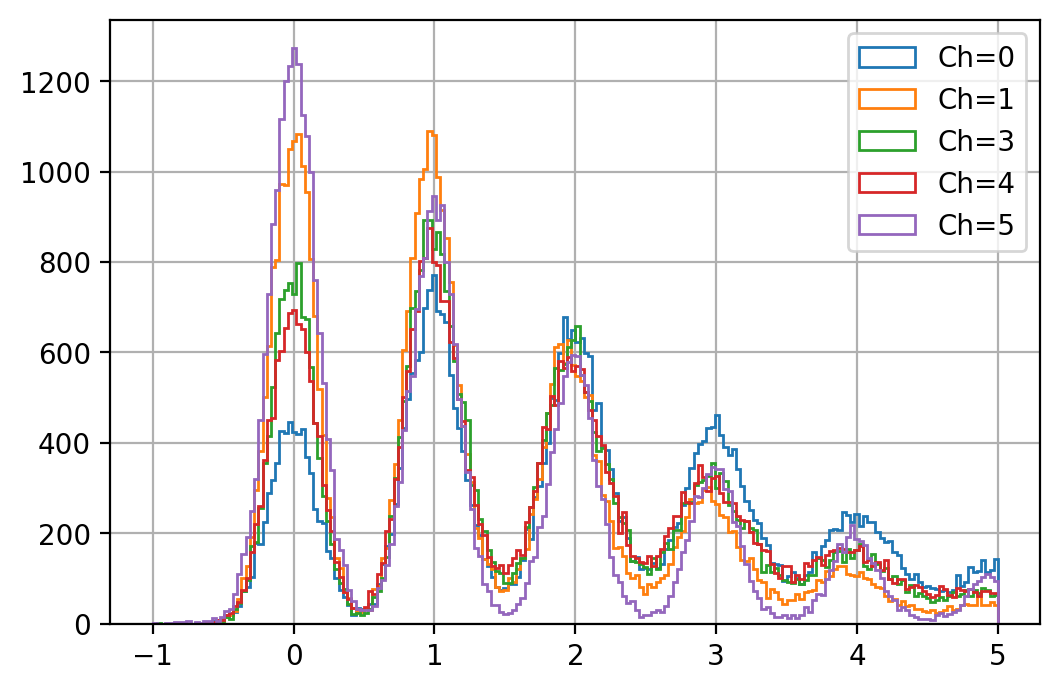

In [4]:
# WEEK="APSAIA_VUV_2";
# WEEK="APSAIA_VIS";
# WEEK="APSAIA_VUV";
WEEK="DAPHNE_VIS";
WEEK="DAPHNE_VUV";


compress=False

OV=9


path="/scr/neutrinos/rodrigoa/"+WEEK+"/joython/"
Runs=open_runs_table("../macros/"+WEEK+".xlsx")

Calib_run=Runs[(Runs["Type"]=="Calibration") & ( Runs["OverVoltageXA"]==OV)].iloc[0] #1st run, lower intensity 
print(Calib_run)
run=Calib_run["Run"]


plt.figure(dpi=200)

for ch in Calib_run["Channels"]:

    ADCsxticks2PE=GetGains(WEEK,OV)[Chan_dic[ch]]
    run_path=path+"run"+str(run).zfill(2)+"/";
    Charge_vars   = open_ch_var(run_path ,"Charge_vars"   ,ch,compressed=compress)
    Peak_vars     = open_ch_var(run_path  ,"Peak_vars"   ,ch,compressed=compress)
    Pedestal_vars = open_ch_var(run_path  ,"Pedestal_vars_SW"   ,ch,compressed=compress)

    #plot charge distribution from raw calibration data
    for charge in ["ChargeRangeAverageWvf"]:
    
        plt.hist(Charge_vars[charge]*ADCsxticks2PE,bins=200,range=(-1,5),histtype="step",label="Ch="+str(ch))
    PEs=Charge_vars[charge]*ADCsxticks2PE
    
    P0=np.sum(PEs<0.5)/PEs.shape[0]
    P1=np.sum((PEs>0.5)*(PEs<1.5))/PEs.shape[0]
    l=-np.log(P0)
    p=1-P1/(l*P0)
    print(ch,l,"\t",p)
    
plt.legend()
plt.grid()